# NLP Project : Toxic comment detection
### Authors : Corentin ODIC & Michaël SOUMM

In this project, our goal will be to detect wether a comment left on a website may be "toxic", in the sence that it could be offensive or even dangerous. We propose to use the following kaggle database to work with : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data. 

It contains over 2 million comments sampled from the Civil Comments platform, an open archive created so that researchers could understand and improve civility in online conversations for years to come.

Let us start by importing the database and our main modules :

## Various imports 

Downloading the database :

In [2]:
!wget https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0 -O train.csv.zip
!unzip train.csv.zip

--2021-04-23 10:48:43--  https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sbiotru4wlr3ykj/train.csv.zip [following]
--2021-04-23 10:48:43--  https://www.dropbox.com/s/raw/sbiotru4wlr3ykj/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd6d07ba5e8f359e967634a9ba7.dl.dropboxusercontent.com/cd/0/inline/BNKxSlQ3oLW4AbfAVruO8-4F1awLwP36wwKHBirgbCK5K1MZYwcN8Zb4Kbj_MGzJuubYDN4KBonySnW-bevgwvmDDvFQPeEksN0mQPi47gJHCx3QmZ-Y3y4Q1cFcJ1m5DaL8kiXpkGd4O_GWXmbx_63T/file# [following]
--2021-04-23 10:48:43--  https://ucd6d07ba5e8f359e967634a9ba7.dl.dropboxusercontent.com/cd/0/inline/BNKxSlQ3oLW4AbfAVruO8-4F1awLwP36wwKHBirgbCK5K1MZYwcN8Zb4Kbj_MGzJuubYDN4KBonySnW-be

Installing and importing modules :

In [52]:
!pip install transformers -q
!pip install livelossplot -q

In [51]:
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import pandas as pd
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, AutoModel, AutoTokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses

if torch.cuda.is_available():    
    print("Using GPU")
    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Using GPU


## Description of the database

### Features

We can now load the database :

In [5]:
df = pd.read_csv('train.csv')
df.head()

id    target  ... identity_annotator_count  toxicity_annotator_count
0  59848  0.000000  ...                        0                         4
1  59849  0.000000  ...                        0                         4
2  59852  0.000000  ...                        0                         4
3  59855  0.000000  ...                        0                         4
4  59856  0.893617  ...                        4                        47

[5 rows x 45 columns]

As we see, we have many interesting columns.

The main one is the `target`, which gives us a score for the toxicity. As a baseline taken from the Kaggle challenge, we consider a comment as toxic iff `target` $\geq$ 0.5. This column will be our main indicator.

In [49]:
df['target'].isna().sum()

0

All the values are well defined.

Additionnaly, every toxic comment has a subtype score for: 
- severe_toxicity
- obscene
- threat
- insult
- identity_attack
- sexual_explicit

These help to mesure the type of toxicity we can be dealing with.

Finally, some toxic comments were labeled with an identity that has been cited in the text, within the following possibilities :
- male
- female
- transgender
- other_gender
- heterosexual
- homosexual_gay_or_lesbian
- bisexual
- other_sexual_orientation
- christian
- jewish
- muslim
- hindu
- buddhist
- atheist
- other_religion
- black
- white
- asian
- latino
- other_race_or_ethnicity
- physical_disability
- intellectual_or_learning_disability
- psychiatric_or_mental_illness
- other_disability



We will first train a model to predict the toxicity score of a comment, and then finetune it to see if we can predict other attributes.

### First simple analysis

We need to first understand the toxicity score and check if it can be simply explained.

We first check if there is a link between the toxicity and the polarity of a sentence, using `nltk`'s sentiment analysis:

In [ ]:
def polarity(x):
    if type(x) == str:
        return SIA.polarity_scores(x)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
df["polarity"] = df["comment_text"].apply(polarity)

We check for a potential correlation by categorising the database into 4 types : 
- non toxic comments
- mildly toxic comments
- fairly toxic comments
- very toxic comments

In [ ]:
df["negativity"] = df["polarity"].apply(lambda x: x["neg"]).apply(lambda x: float(x))
 
nums_1 = df.sample(frac=0.1).query("target ==0")["negativity"]
nums_2 = df.sample(frac=0.1).query("target<= 0.33 and target>0")["negativity"]
nums_3 = df.sample(frac=0.1).query("target<= 0.66 and target>0.33")["negativity"]
nums_4 = df.sample(frac=0.1).query("target>0.66")["negativity"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2, nums_3, nums_4],
                         group_labels=["Non toxique", "Peu toxique","Plutôt toxique","Très toxique"],
                         colors=["green","dodgerblue","darkorange","red"], show_hist=False)

fig.update_layout(title_text="Negativity vs. Toxicity", xaxis_title="Negativity", template="simple_white")
fig.show()


As we see, the more toxic a comment is, the more likely it to have a negative polarity. Nevertheless, the difference in the polarity is not that clear between our categories, meaning that toxicity detection will require a custom model

Class imbalance :

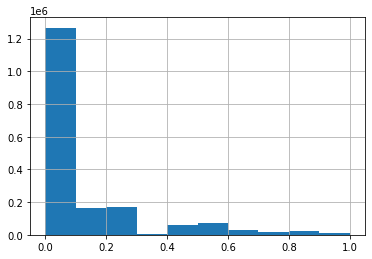

In [ ]:
df['target'].hist()

D'apres kaggle, la baseline est "mauvais commentaire $\Leftrightarrow$ toxic $\ge$ 0.5", donc grosse class unbalance

On construit une base plus petite en prennant 25,000 phrases de toxitié nulle, 12,500 de toxitité >=0.5, et 12,500 entre 0 et 0.5

In [6]:
# n = nombre de phrases a prendre (trop long pour faire les tests)
df = pd.concat([df[df['target'] >= 0.5].sample(n=25000), df[df['target'] == 0].sample(n=12500), df[df['target'].between(0, 0.5, inclusive=False)].sample(n=12500)])

In [7]:
sentences = df.comment_text.values
labels = df.target.values

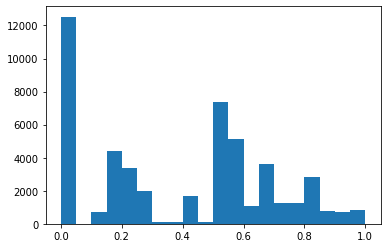

In [ ]:
plt.hist(labels, bins=20);

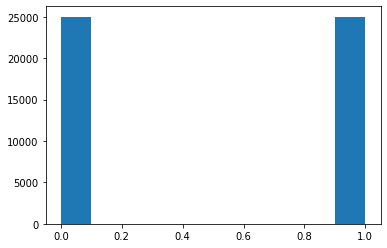

In [ ]:
plt.hist((labels>=0.5).astype(float));

Preprocessing des phrases

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Tokenisation selon les normes de BERT (avec l'option add_special_tokens qui met les BOS/EOS) 

In [9]:
inputs = []

for sentence in tqdm(sentences, position=0):
    encoded_sent = tokenizer.encode(sentence,                  
                                    add_special_tokens = True, 
                                    )
    
    inputs.append(encoded_sent)

100%|██████████| 50000/50000 [01:09<00:00, 723.53it/s]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in inputs]))

Max sentence length:  283


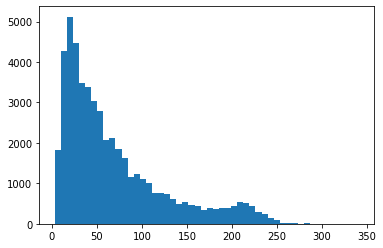

In [10]:
from matplotlib import pyplot as plt
sizes = [len(sen) for sen in inputs]
plt.hist(sizes, bins=50);

In [11]:
import numpy as np
inputs_idx = np.argwhere(np.array(sizes) <= 128)
clean_inputs = []
clean_labels = []

for i, input in enumerate(inputs):
    if sizes[i] <= 128:
        clean_inputs.append(input)
        clean_labels.append(labels[i])

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in clean_inputs]))

Max sentence length:  128


In [12]:
MAX_LEN = 128

clean_inputs = pad_sequences(clean_inputs, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [13]:
attention_masks = []

for sent in clean_inputs:    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

In [14]:
# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(clean_inputs, clean_labels, 
                                                            random_state=2021, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, clean_labels,
                                             random_state=2021, test_size=0.2)

In [15]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
class ToxicPredictor(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(ToxicPredictor, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        #we append extra layer for predicting toxicity  
        h = 1
        # for 2 hidden layers use :
        #h = 100
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.encoder.pooler.dense.out_features, h)
        #self.fc2 = nn.Linear(h, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps = self.encoder(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        x = cont_reps["pooler_output"]
        x = self.dropout(x)
        x = self.fc1(x)
        # x = self.fc2(F.ReLU(x))

        return torch.sigmoid(x)

In [31]:
import gc
del model
gc.collect()

695

In [32]:
model = ToxicPredictor('bert-base-uncased').to(device)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

for param in model.encoder.pooler.parameters():
    param.requires_grad = True
for param in model.encoder.encoder.layer[11].parameters():
    param.requires_grad = True

In [33]:
# define the loss and optimizer 
criterion = nn.BCELoss()
#opti = optim.Adam([{'params':model.fc2.parameters()}, {'params':model.fc1.parameters()}], lr = 1e-3)
"""
opti = optim.Adam([{'params': model.fc2.parameters(),                       'lr': 1e-3},
                   {'params': model.fc1.parameters(),                       'lr': 1e-3}, 
                   {'params': model.encoder.pooler.parameters(),            'lr': 1e-4},
                   {'params': model.encoder.encoder.layer[11].parameters(), 'lr': 1e-4}
                   ])
"""
opti = optim.Adam([{'params': model.fc1.parameters(),'lr': 1e-3}, 
                   {'params': model.encoder.parameters(), 'lr': 1e-5},
                   ])

In [36]:
def train(model, criterion, opti, train_loader, val_loader, epochs=1):
    liveloss = PlotLosses()
    best_acc = 0

    for epoch in range(epochs):
        #########
        # Train #
        #########
        model.train()
        logs = {}
        tot_loss = 0
        correct  = 0
        for it, (seq, attn_masks, labels) in tqdm(enumerate(train_loader), position=0, total=len(train_loader)):
            #Clear gradients
            opti.zero_grad()  

            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            # Getting prediction
            preds = model(seq, attn_masks).view(-1)

            #Computing loss
            loss = criterion(preds, labels.float())

            #Backpropagating the gradients
            loss.backward()
            tot_loss += loss.item()

            #Optimization step
            opti.step()

            # number of correct items
            true_toxic = (labels >= 0.5)
            pred_toxic = (preds  >= 0.5)

            correct += (true_toxic == pred_toxic).float().sum().item()

        # Show results
        logs['loss'] = tot_loss/len(train_loader.dataset)
        logs['accuracy'] = 100*correct/len(train_loader.dataset)

        ##############
        # Validation #
        ##############
        model.eval()  
        loss_val    = 0  
        correct_val = 0
        for it, (seq, attn_masks, labels) in tqdm(enumerate(val_loader), position=0, total=len(val_loader)): 
            # Same as in train 

            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            preds_val = model(seq, attn_masks).view(-1)
        
            loss = criterion(preds_val, labels.float())
  
            loss_val += loss.item()

            true_toxic = (labels >= 0.5)
            pred_toxic = (preds_val >= 0.5)

            correct_val += (true_toxic == pred_toxic).float().sum().item()

        # Save the best model on validation
        acc = 100*correct_val/len(val_loader.dataset)
        if acc > best_acc:
            torch.save(model.state_dict(), "best_model.pth")
            best_acc = acc

        # Show results
        logs['val_loss'] = loss_val/len(val_loader.dataset)    
        logs['val_accuracy'] = acc

        liveloss.update(logs)
        liveloss.send()

Training whole model :

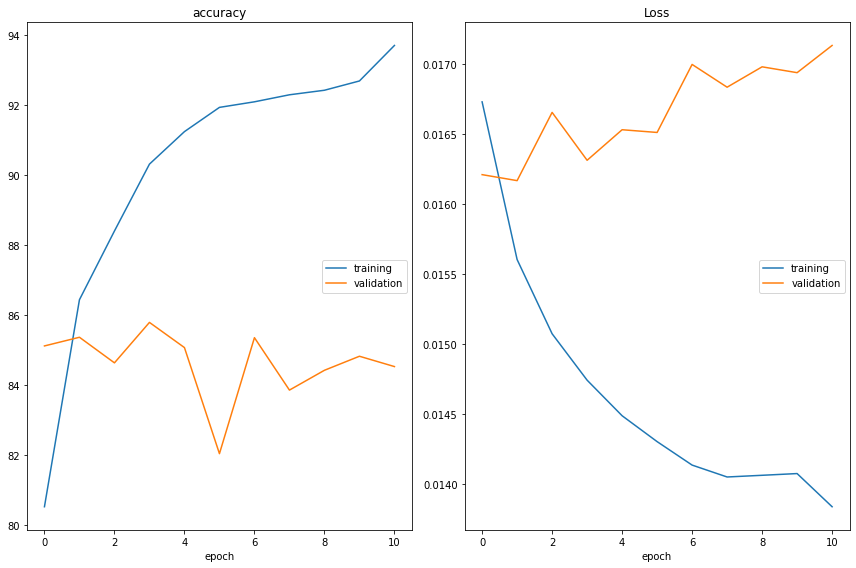

  0%|          | 0/1061 [00:00<?, ?it/s]

accuracy
	training         	 (min:   80.533, max:   93.705, cur:   93.705)
	validation       	 (min:   82.049, max:   85.797, cur:   84.536)
Loss
	training         	 (min:    0.014, max:    0.017, cur:    0.014)
	validation       	 (min:    0.016, max:    0.017, cur:    0.017)


 74%|███████▍  | 790/1061 [17:06<05:51,  1.30s/it]

KeyboardInterrupt: ignored

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

Training last 2 Linear layers :

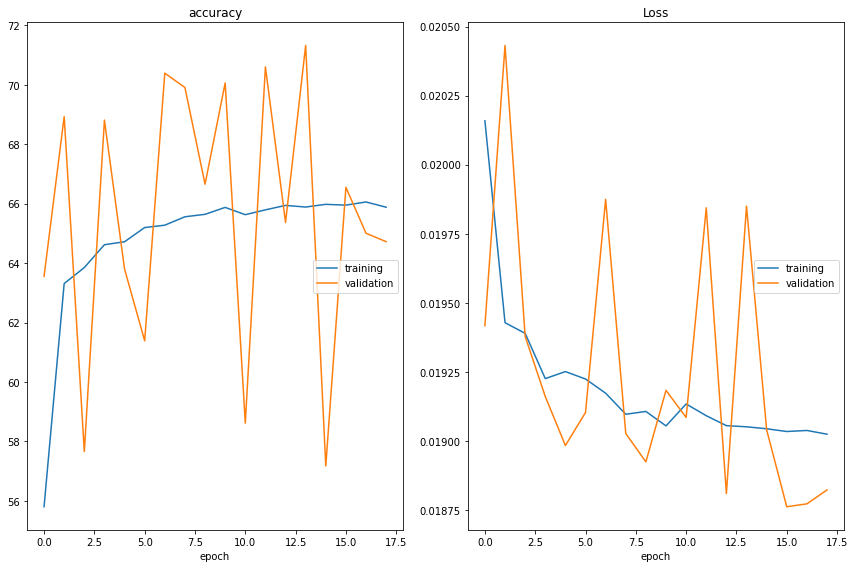

  0%|          | 0/1061 [00:00<?, ?it/s]

accuracy
	training         	 (min:   55.805, max:   66.058, cur:   65.881)
	validation       	 (min:   57.178, max:   71.322, cur:   64.722)
Loss
	training         	 (min:    0.019, max:    0.020, cur:    0.019)
	validation       	 (min:    0.019, max:    0.020, cur:    0.019)


 90%|████████▉ | 953/1061 [07:39<00:51,  2.08it/s]

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

Training last encoder + pooler + last 2 Linear layers :

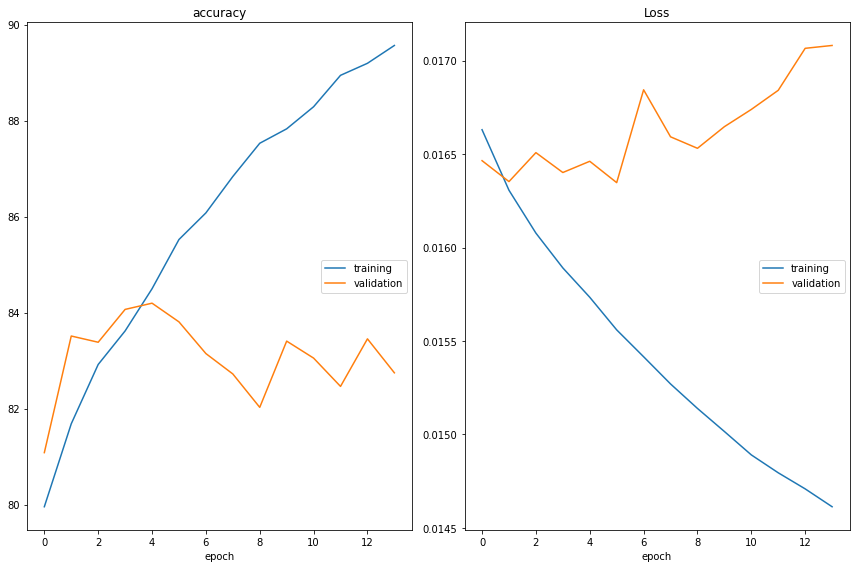

  0%|          | 0/1060 [00:00<?, ?it/s]

accuracy
	training         	 (min:   79.956, max:   89.565, cur:   89.565)
	validation       	 (min:   81.083, max:   84.196, cur:   82.746)
Loss
	training         	 (min:    0.015, max:    0.017, cur:    0.015)
	validation       	 (min:    0.016, max:    0.017, cur:    0.017)


 95%|█████████▌| 1009/1060 [08:31<00:25,  1.98it/s]

KeyboardInterrupt: ignored

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

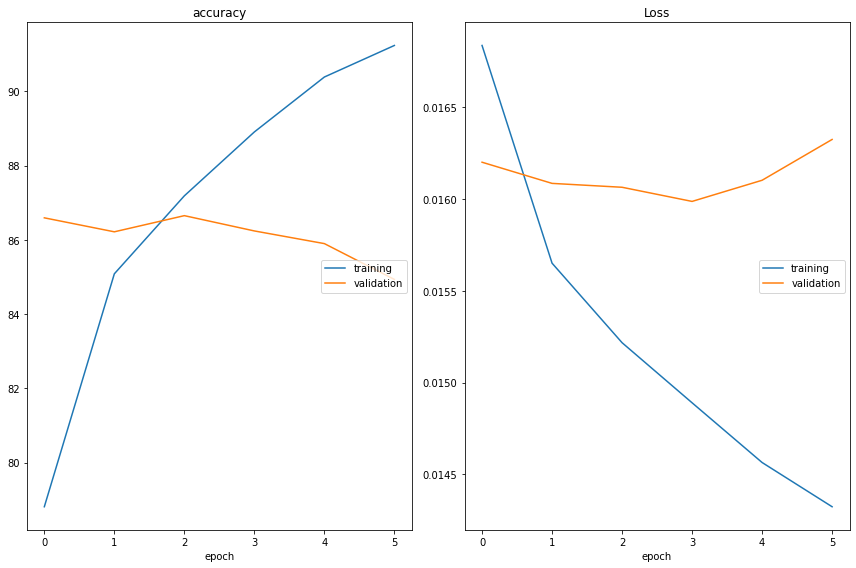

  0%|          | 0/1063 [00:00<?, ?it/s]

accuracy
	training         	 (min:   78.811, max:   91.233, cur:   91.233)
	validation       	 (min:   84.933, max:   86.650, cur:   84.933)
Loss
	training         	 (min:    0.014, max:    0.017, cur:    0.014)
	validation       	 (min:    0.016, max:    0.016, cur:    0.016)


 76%|███████▌  | 806/1063 [09:09<02:55,  1.47it/s]

KeyboardInterrupt: ignored

In [37]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

In [ ]:
seq, attn_masks, labels = next(iter(validation_dataloader))
preds = model(seq.to(device), attn_masks.to(device))

In [ ]:
for i in range(len(seq)):
    print("===============")
    print(tokenizer.decode(seq[i]))
    print("predicted", preds[i].item())
    print("real", labels[i].item())

[CLS] heya! i do not travel much, but i found this article to be quite intriguing. if more people were conscientious about carry - ons and such, and how much they bring, i think lines would be a lot smaller. thanks for putting this great article out, scott! : ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
predicted 0.00024107070930767804
real 0.0
[CLS] if one isn't female but self identifies as such do they benefit from the budget or do they need to get started on making the change? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]